#Finetuning Gpt-2 base model for medical quesiton answering.



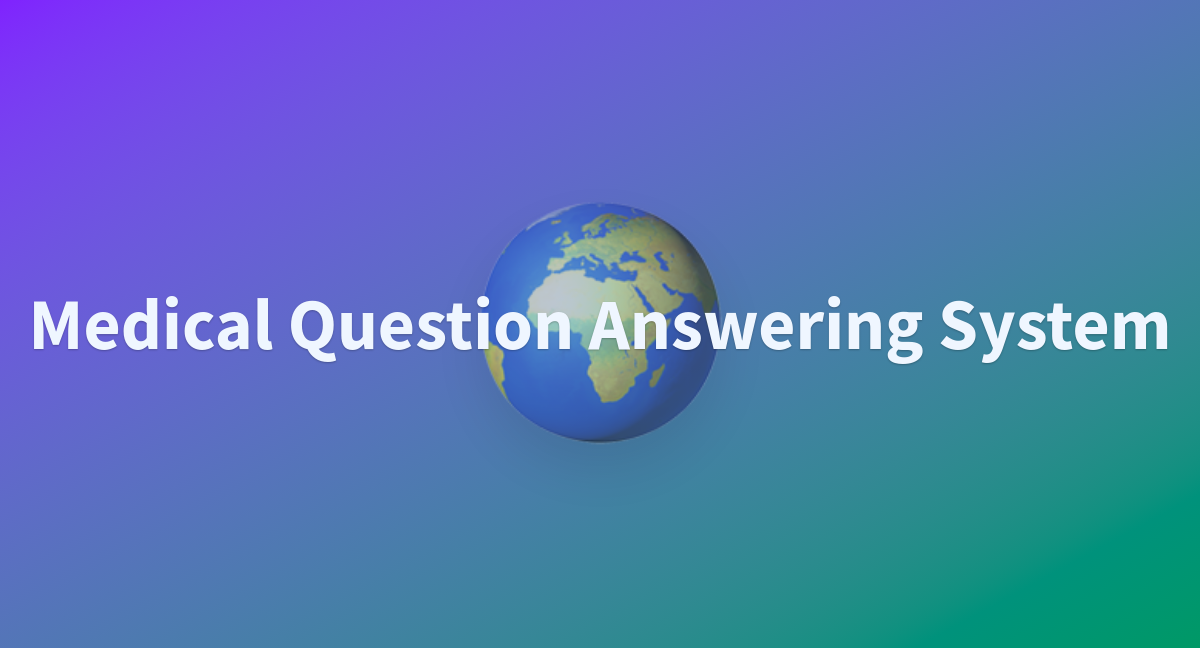

## Installing necessary libaries for finetuning



In [2]:
pip install transformers datasets torch pandas


# Logging into Hugging Face to load the model after Finetuing




In [ ]:
from huggingface_hub import login
login()


# Loading the dataset from csv file

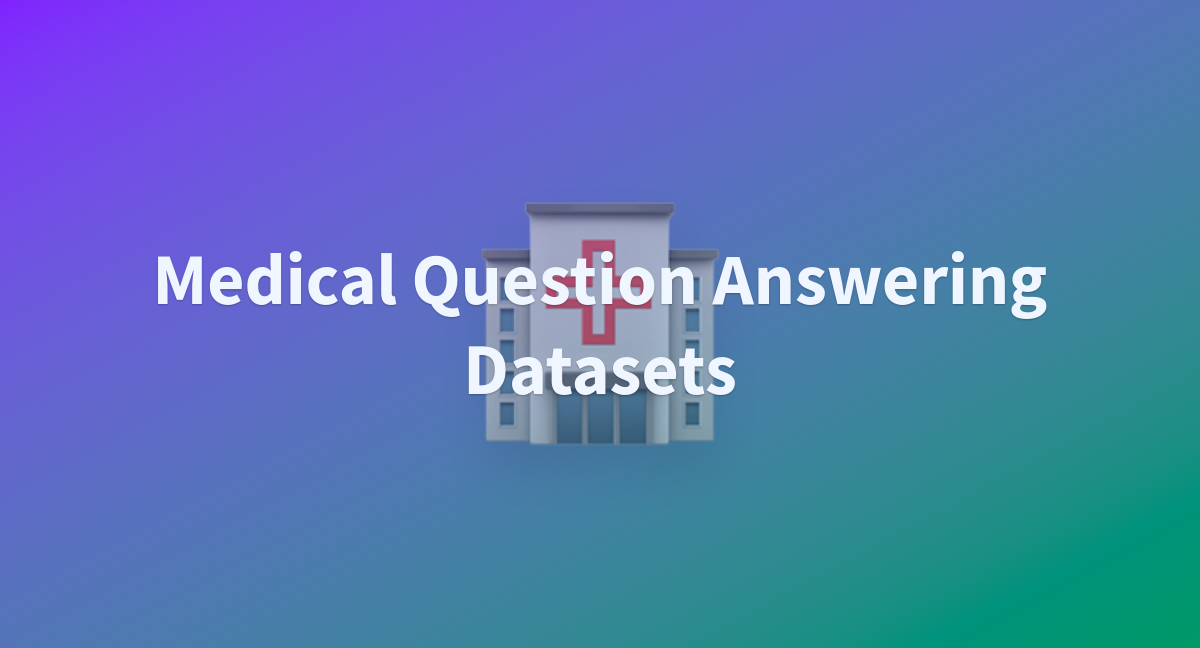

Sample of dataset


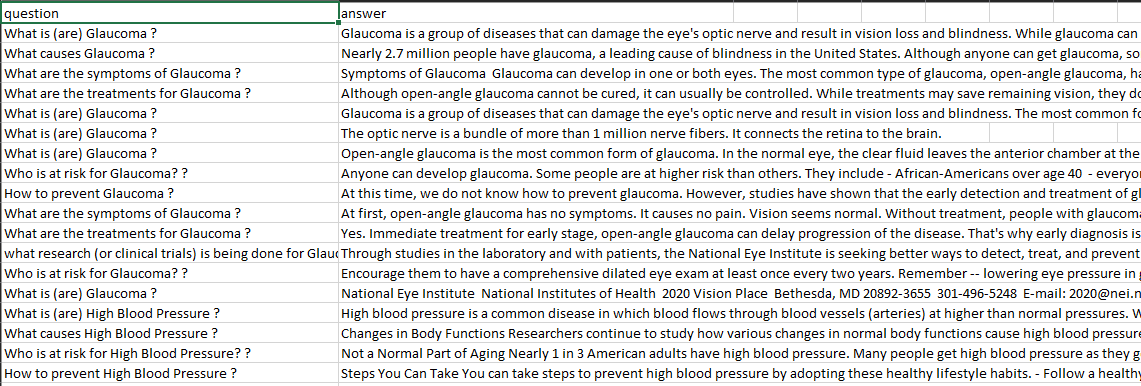

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments


file_path = "/content/Final data set for llm based health assitance (1).csv"
df = pd.read_csv(file_path)


df.columns = ['question', 'answer']


df = df.dropna()


model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)


tokenizer.pad_token = tokenizer.eos_token

df["prompt"] = "Question: " + df["question"] + "\nAnswer: "
df["response"] = df["answer"]


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import Dataset

class GPTQADataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        prompt = self.data.iloc[index]["prompt"]
        response = self.data.iloc[index]["response"]
        full_text = prompt + response

        inputs = self.tokenizer(
            full_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": inputs["input_ids"].squeeze()
        }


train_size = int(0.8 * len(df))
train_df, val_df = df[:train_size], df[train_size:]


train_dataset = GPTQADataset(train_df, tokenizer)
val_dataset = GPTQADataset(val_df, tokenizer)


In [ ]:

model = AutoModelForCausalLM.from_pretrained(model_name)


training_args = TrainingArguments(
    output_dir="./gpt_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none",
    push_to_hub=False
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)


trainer.train()


model.save_pretrained("/content/fine_tuned_gpt")
tokenizer.save_pretrained("/content/fine_tuned_gpt")

print("Model fine-tuned and saved!")


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-01fe454bbfac>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,0.762400,0.819653
2,0.686600,0.796789
3,0.646700,0.793209


Model fine-tuned and saved!


In [ ]:
pip install datasets  huggingface_hub


In [ ]:
from huggingface_hub import notebook_login
notebook_login()


# Uploading the model to Hugging Face

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from huggingface_hub import HfApi


hf_repo = "Ganesh19128734/fine-tuned-gpt-project"


model_path = "/content/fine_tuned_gpt"
model = AutoModelForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)


model.push_to_hub(hf_repo)
tokenizer.push_to_hub(hf_repo)

print(f"Model uploaded to: https://huggingface.co/{hf_repo}")


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Model uploaded to: https://huggingface.co/Ganesh19128734/fine-tuned-gpt-project


# Testing the finetuned model with questions.




In [17]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

def get_answer(question, model_path="Ganesh19128734/fine-tuned-gpt-project"):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path)

    tokenizer.pad_token = tokenizer.eos_token

    prompt = f"Question: {question}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)

    model.eval()
    with torch.no_grad():
        output = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=300,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)


    if "Answer:" in generated_text:
        answer = generated_text.split("Answer:")[1].strip()
    else:
        answer = generated_text[len(prompt):].strip()

    if '?' in answer:
        answer = answer.split('?', 1)[-1].strip()

    return answer

sample_question = "What are the potential side effects of ibuprofen?"
response = get_answer(sample_question)

print("Question:", sample_question)
print("Answer:", response)


Question: What are the potential side effects of ibuprofen?
Answer: The effects of ibuprofen on the body depend on the amount of the drug. Some people who take ibuprofen do not need to take it, while others take it for no other reason than to avoid some serious health problems. Other effects of ibuprofen may include       -  Pain when using ibuprofen    -  Tension    -  Muscle cramps        The side effects of ibuprofen depend on the amount of the drug. Some people who take ibuprofen do not need to take it, while others take it for no other reason than to avoid some serious health problems. Other effects of ibuprofen may include      -  Pain when using ibuprofen     -  Tension         People who take ibuprofen often have other health problems, such as infections, heart disease, or autoimmune diseases.
